In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.svm import SVC
import datetime
import pickle

In [4]:
data = pd.read_csv("smoke_detection_iot.csv")
data.sample(5)

Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  \
47618       47618  1654783967          26.200        51.70       1249   
13278       13278  1654746609          20.467        47.34       1122   
30804       30804  1654767153          19.600        55.41         13   
52113       52113  1654713158          26.270        46.70         84   
31225       31225  1654767574          19.260        55.20        175   

       eCO2[ppm]  Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  \
47618        400   12982        19411        938.768   1.84   1.92  12.69   
13278        527   12843        19457        938.909   2.20   2.28  15.14   
30804        400   13251        20225        939.694   2.38   2.47  16.37   
52113        400   12788        20666        937.543   2.19   2.27  15.06   
31225        400   13164        20084        939.659   0.99   1.03   6.83   

       NC1.0  NC2.5    CNT  Fire Alarm  
47618  1.979  0.045  22624           1  
13278  2.360  0.053  13278           1  
30804  2.552  0.058   5810           1  
52113  2.349  0.053    971           0  
31225  1.065  0.024   6231           1

In [6]:
data.shape

(62630, 16)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62630 non-null  float64
 1   Temperature[C]  62630 non-null  float64
 2   Humidity[%]     62630 non-null  float64
 3   TVOC[ppb]       62630 non-null  int64  
 4   eCO2[ppm]       62630 non-null  int64  
 5   Raw H2          62630 non-null  int64  
 6   Raw Ethanol     62630 non-null  int64  
 7   Pressure[hPa]   62630 non-null  float64
 8   PM1.0           62630 non-null  float64
 9   PM2.5           62630 non-null  float64
 10  NC0.5           62630 non-null  float64
 11  NC1.0           62630 non-null  float64
 12  NC2.5           62630 non-null  float64
 13  Fire Alarm      62630 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 6.7 MB


In [23]:
data.describe()

UTC  Temperature[C]   Humidity[%]     TVOC[ppb]     eCO2[ppm]  \
count  62630.000000    62630.000000  62630.000000  62630.000000  62630.000000   
mean   45307.691538       15.970424     48.539499   1942.057528    670.021044   
std    20737.205223       14.359576      8.865367   7811.589055   1905.885439   
min        0.000000      -22.010000     10.740000      0.000000    400.000000   
25%    29903.250000       10.994250     47.530000    130.000000    400.000000   
50%    48578.500000       20.130000     50.150000    981.000000    400.000000   
75%    64235.750000       25.409500     53.240000   1189.000000    438.000000   
max    86399.000000       59.930000     75.200000  60000.000000  60000.000000   

             Raw H2   Raw Ethanol  Pressure[hPa]         PM1.0         PM2.5  \
count  62630.000000  62630.000000   62630.000000  62630.000000  62630.000000   
mean   12942.453936  19754.257912     938.627649    100.594309    184.467770   
std      272.464305    609.513156       1.331344    922.524245   1976.305615   
min    10668.000000  15317.000000     930.852000      0.000000      0.000000   
25%    12830.000000  19435.000000     938.700000      1.280000      1.340000   
50%    12924.000000  19501.000000     938.816000      1.810000      1.880000   
75%    13109.000000  20078.000000     939.418000      2.090000      2.180000   
max    13803.000000  21410.000000     939.861000  14333.690000  45432.260000   

              NC0.5         NC1.0         NC2.5    Fire Alarm  
count  62630.000000  62630.000000  62630.000000  62630.000000  
mean     491.463608    203.586487     80.049042      0.714626  
std     4265.661251   2214.738556   1083.383189      0.451596  
min        0.000000      0.000000      0.000000      0.000000  
25%        8.820000      1.384000      0.033000      0.000000  
50%       12.450000      1.943000      0.044000      1.000000  
75%       14.420000      2.249000      0.051000      1.000000  
max    61482.030000  51914.680000  30026.438000      1.000000

In [24]:
data.isnull().any()

UTC               False
Temperature[C]    False
Humidity[%]       False
TVOC[ppb]         False
eCO2[ppm]         False
Raw H2            False
Raw Ethanol       False
Pressure[hPa]     False
PM1.0             False
PM2.5             False
NC0.5             False
NC1.0             False
NC2.5             False
Fire Alarm        False
dtype: bool

In [25]:
data.isnull().sum()

UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

In [3]:
data.drop(columns=['Unnamed: 0','CNT'],inplace=True)
def extract_time(x:int):
    time = datetime.datetime.fromtimestamp(x)
    time = time.time()
    return time.hour*3600 + time.minute*60 + time.second + time.microsecond*1e-6
data['UTC'] = data['UTC'].apply(extract_time)
data.sample(5)

UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  Raw H2  \
20348  40679.0          12.758        49.37       1163        400   12959   
47229  70578.0          25.060        50.65       1427        424   12956   
44203  67552.0          26.630        49.11       1193        400   12924   
20844  41175.0           5.538        47.38       1316        400   12953   
20829  41160.0           5.777        48.88       1268        400   12959   

       Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  \
20348        19439        938.757   1.94   2.01  13.32  2.077  0.047   
47229        19375        938.696   1.74   1.80  11.96  1.865  0.042   
44203        19427        938.682   1.83   1.90  12.58  1.962  0.044   
20844        19402        938.703   1.96   2.04  13.52  2.109  0.048   
20829        19413        938.692   2.31   2.40  15.93  2.484  0.056   

       Fire Alarm  
20348           1  
47229           1  
44203           1  
20844           1  
20829           1

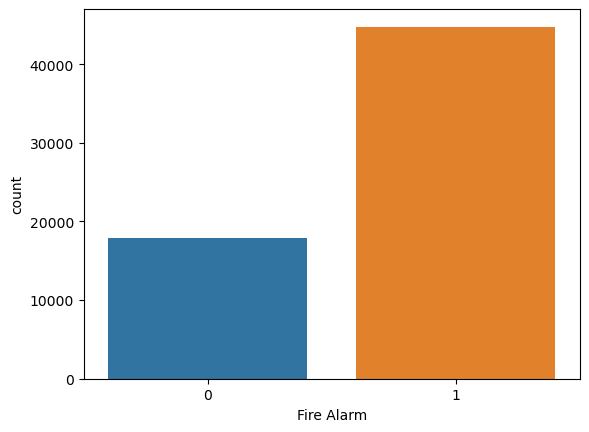

In [4]:
sns.countplot(data=data,x='Fire Alarm')
plt.show()

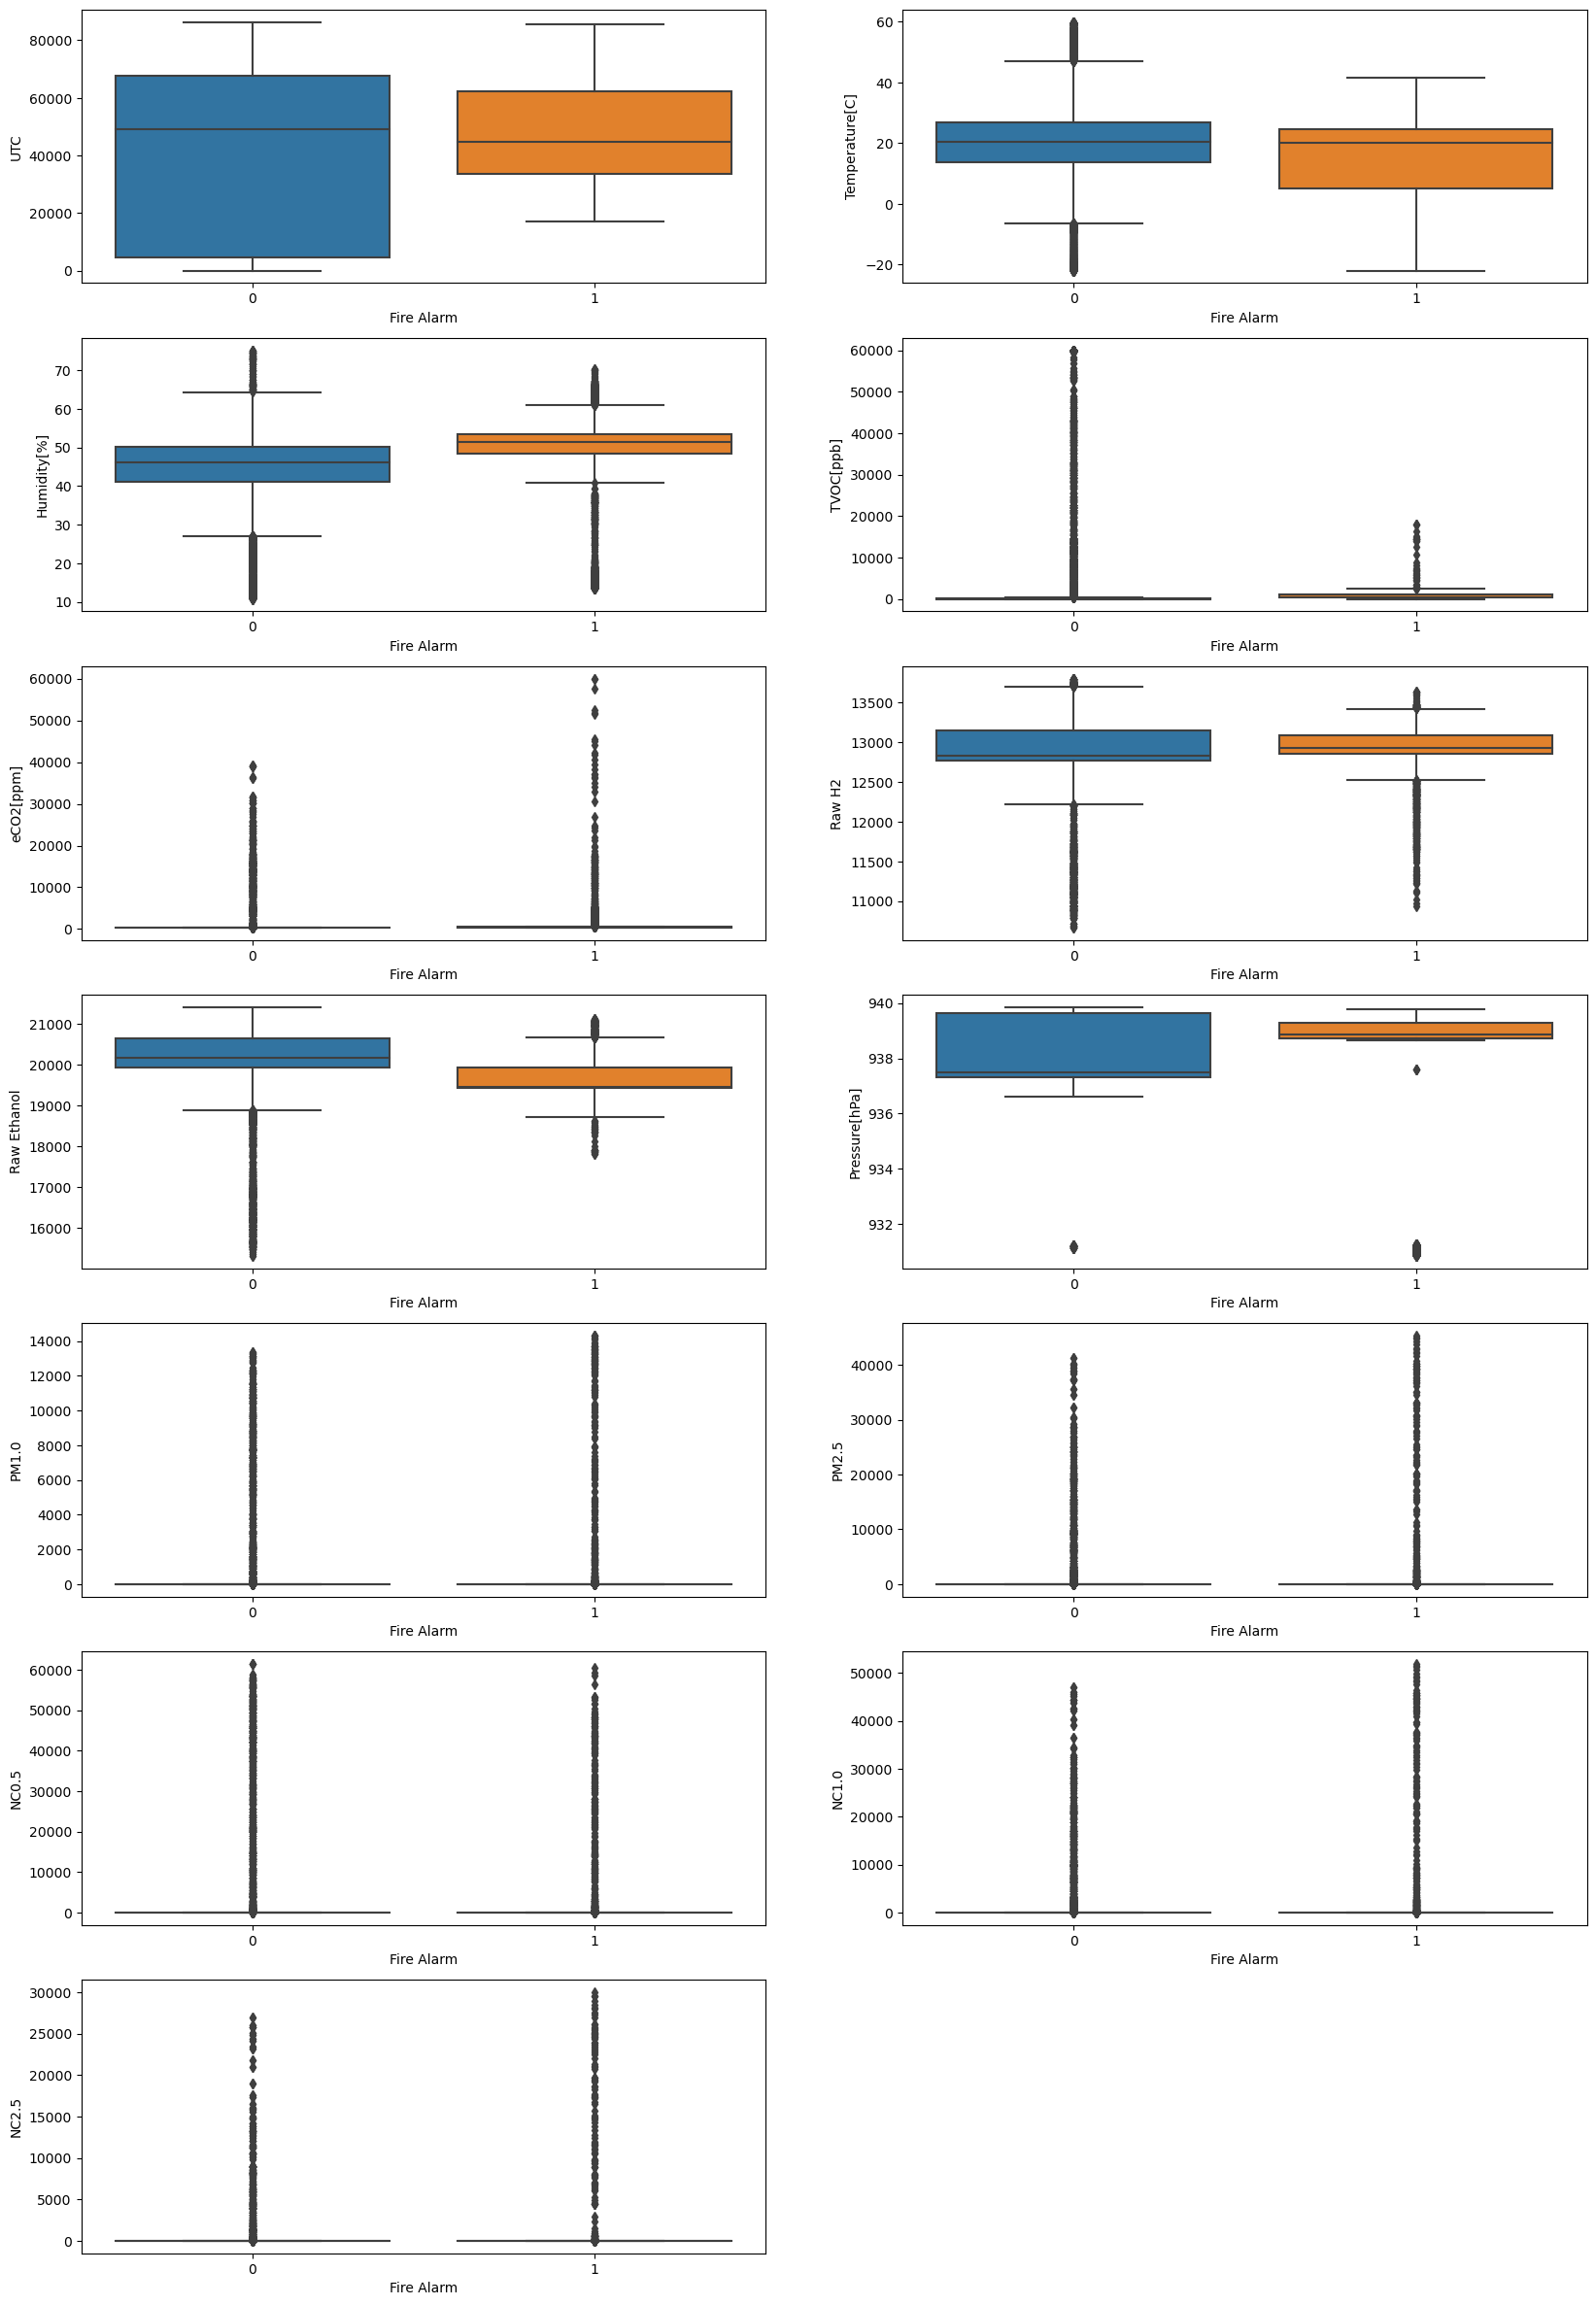

In [5]:
rows = (data.columns.shape[0]-1)//2 + (data.columns.shape[0]-1)%2
cols = 2
plt.figure(figsize=(20,30))
for i,j in enumerate(data.columns.drop('Fire Alarm')):
    plt.subplot(rows,cols,i+1)
    sns.boxplot(y=data[j],x = data['Fire Alarm'])

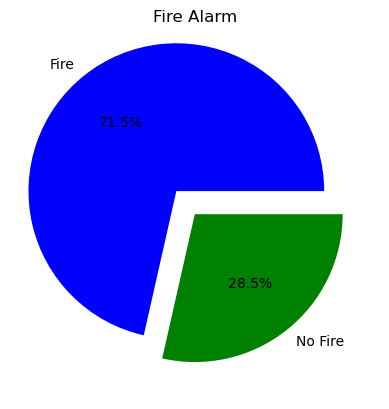

In [6]:
plt.pie(data['Fire Alarm'].value_counts(),[0.2,0],labels=['Fire','No Fire'],autopct='%1.1f%%',colors=['blue','green'])
plt.title('Fire Alarm')
plt.show()

<Axes: xlabel='NC1.0', ylabel='NC2.5'>

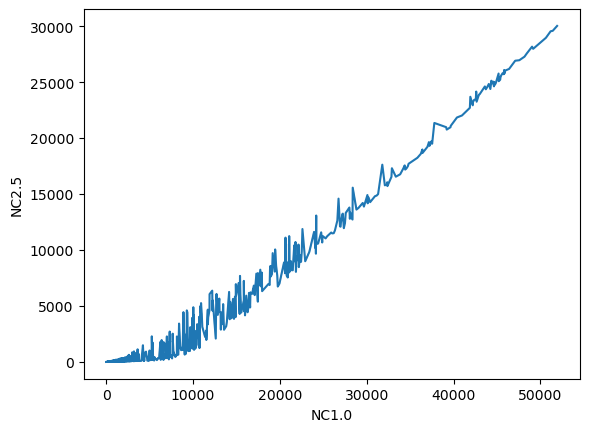

In [7]:
sns.lineplot(x='NC1.0',y='NC2.5',data=data)

<Axes: >

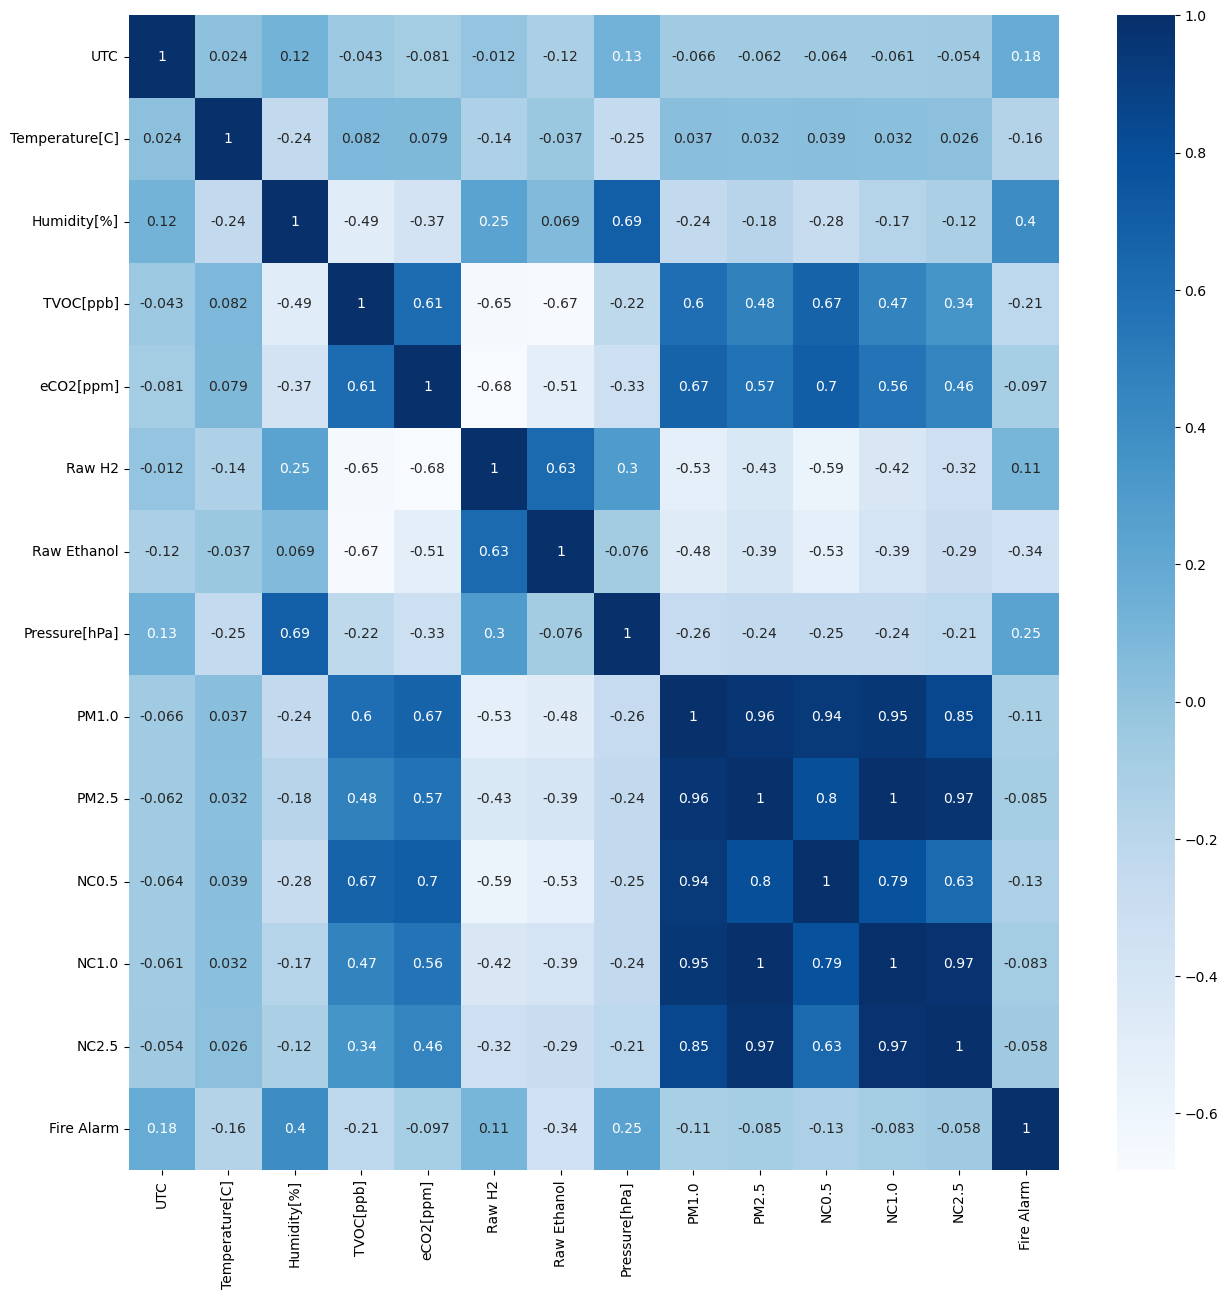

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,cmap="Blues")

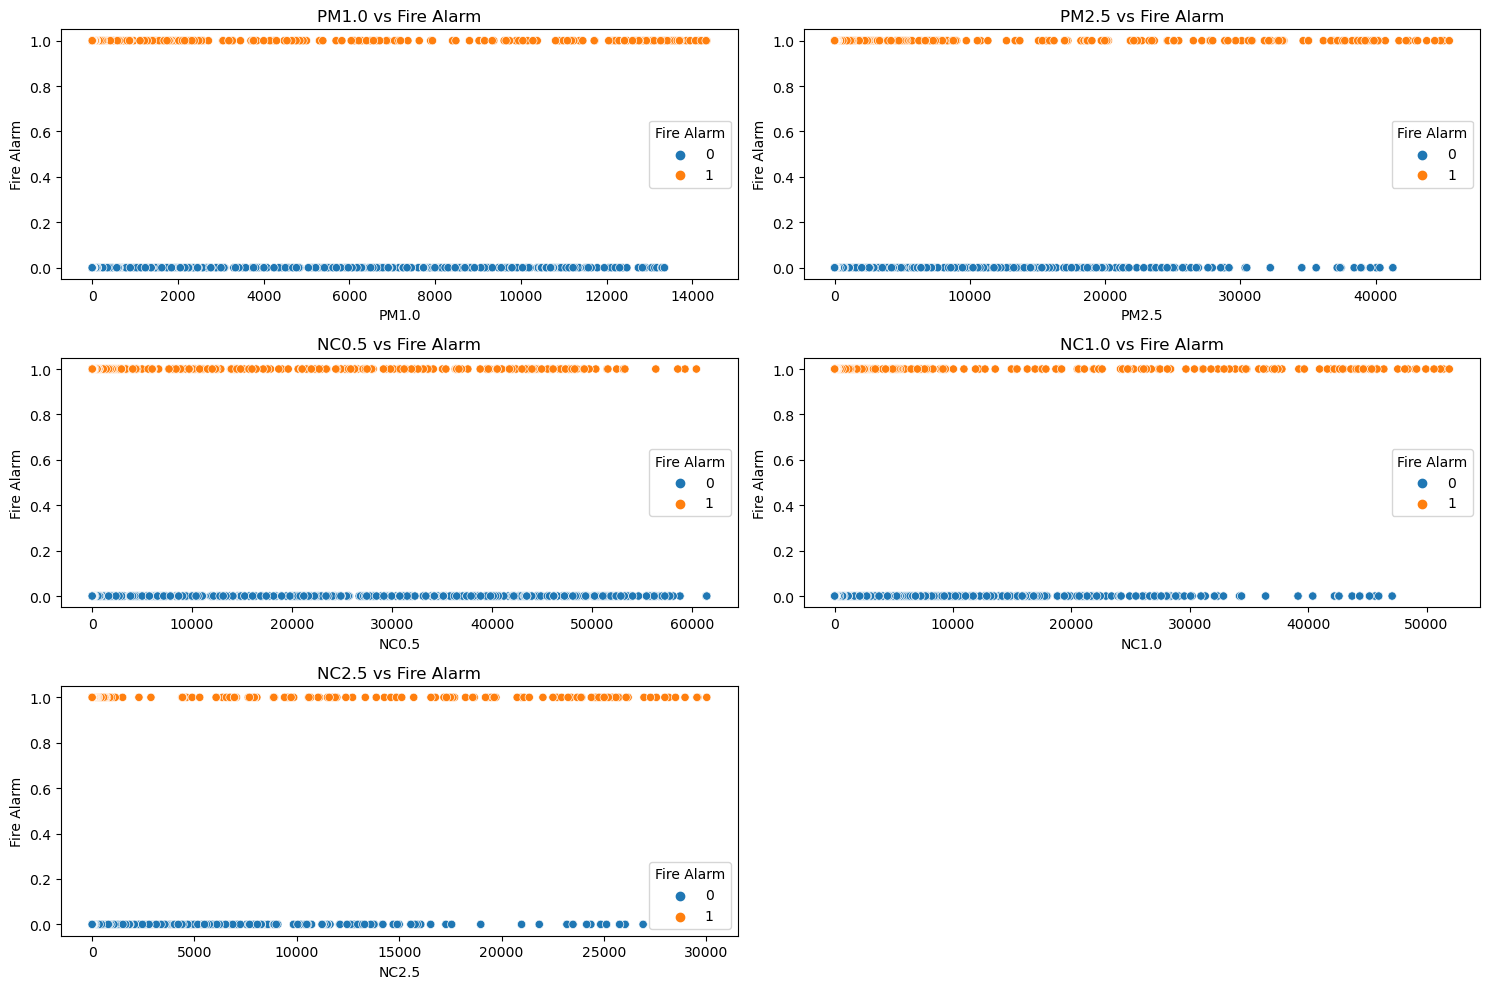

In [9]:
selected_vars = ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']

plt.figure(figsize=(15, 10))

for i, var in enumerate(selected_vars, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=var, y='Fire Alarm', data=data,hue="Fire Alarm")
    plt.title(f'{var} vs Fire Alarm')

plt.tight_layout()

plt.show()

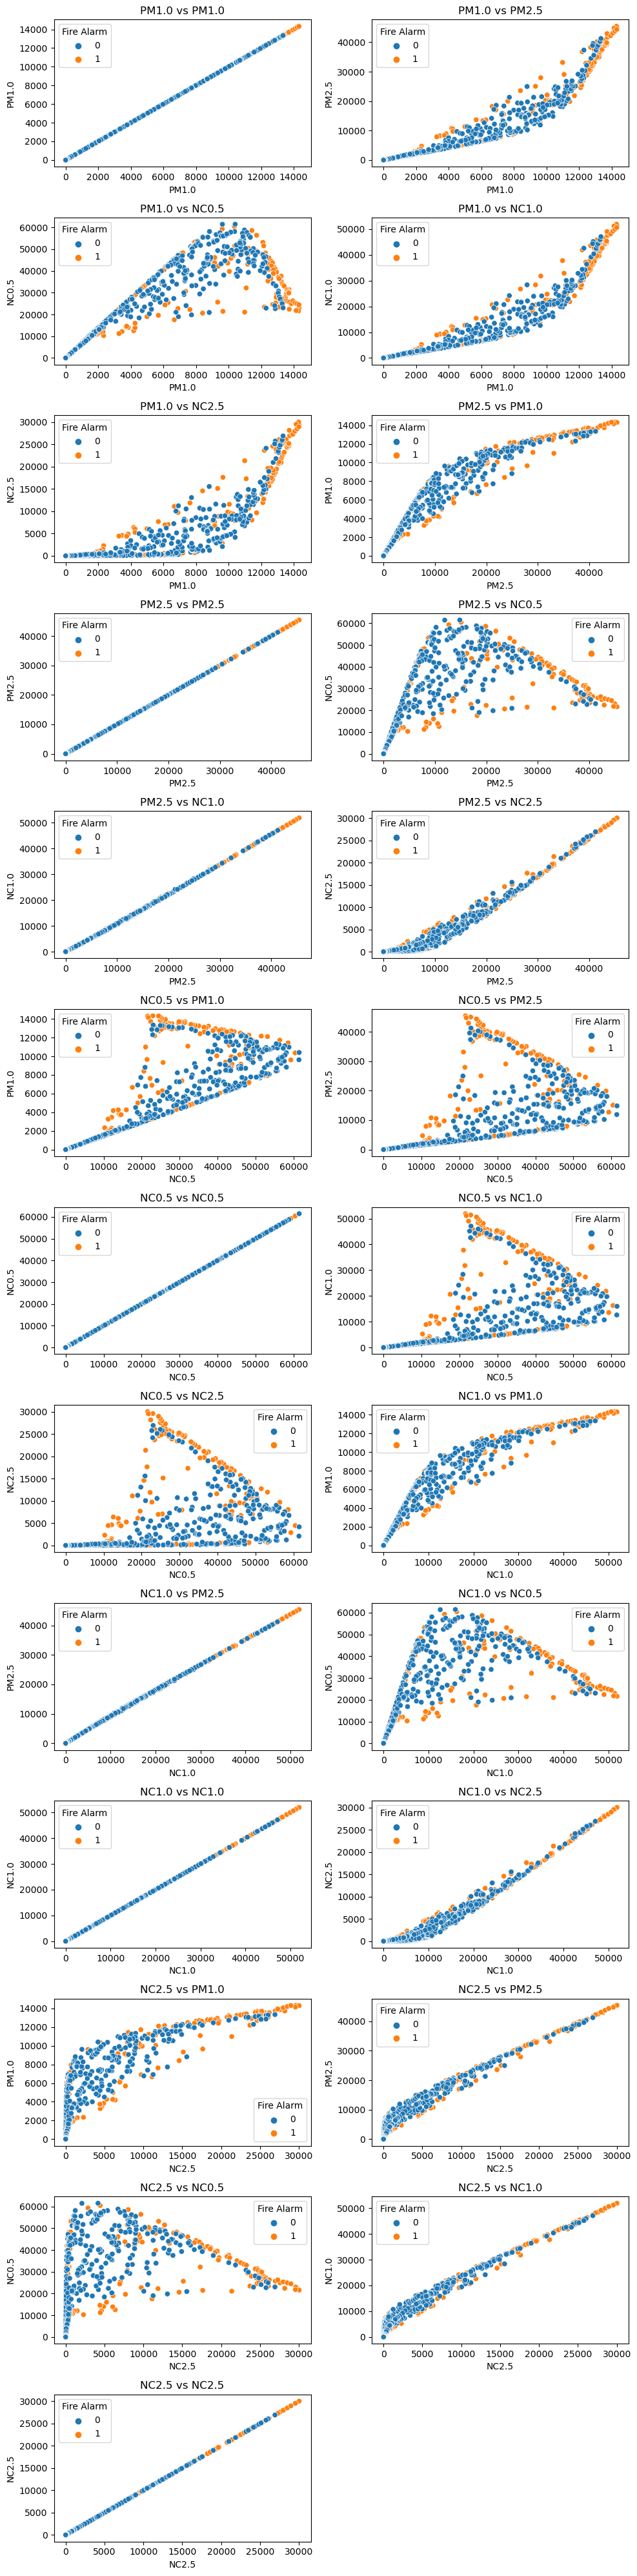

In [10]:
selected_vars = ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']

plt.figure(figsize=(10,40))

v = 1  # Counter for subplot index

for i in selected_vars:
    for j in selected_vars:
        plt.subplot(13, 2, v)
        sns.scatterplot(x=i, y=j, data=data,hue='Fire Alarm')
        plt.title(f'{i} vs {j}')
        v += 1
plt.tight_layout()
plt.show()

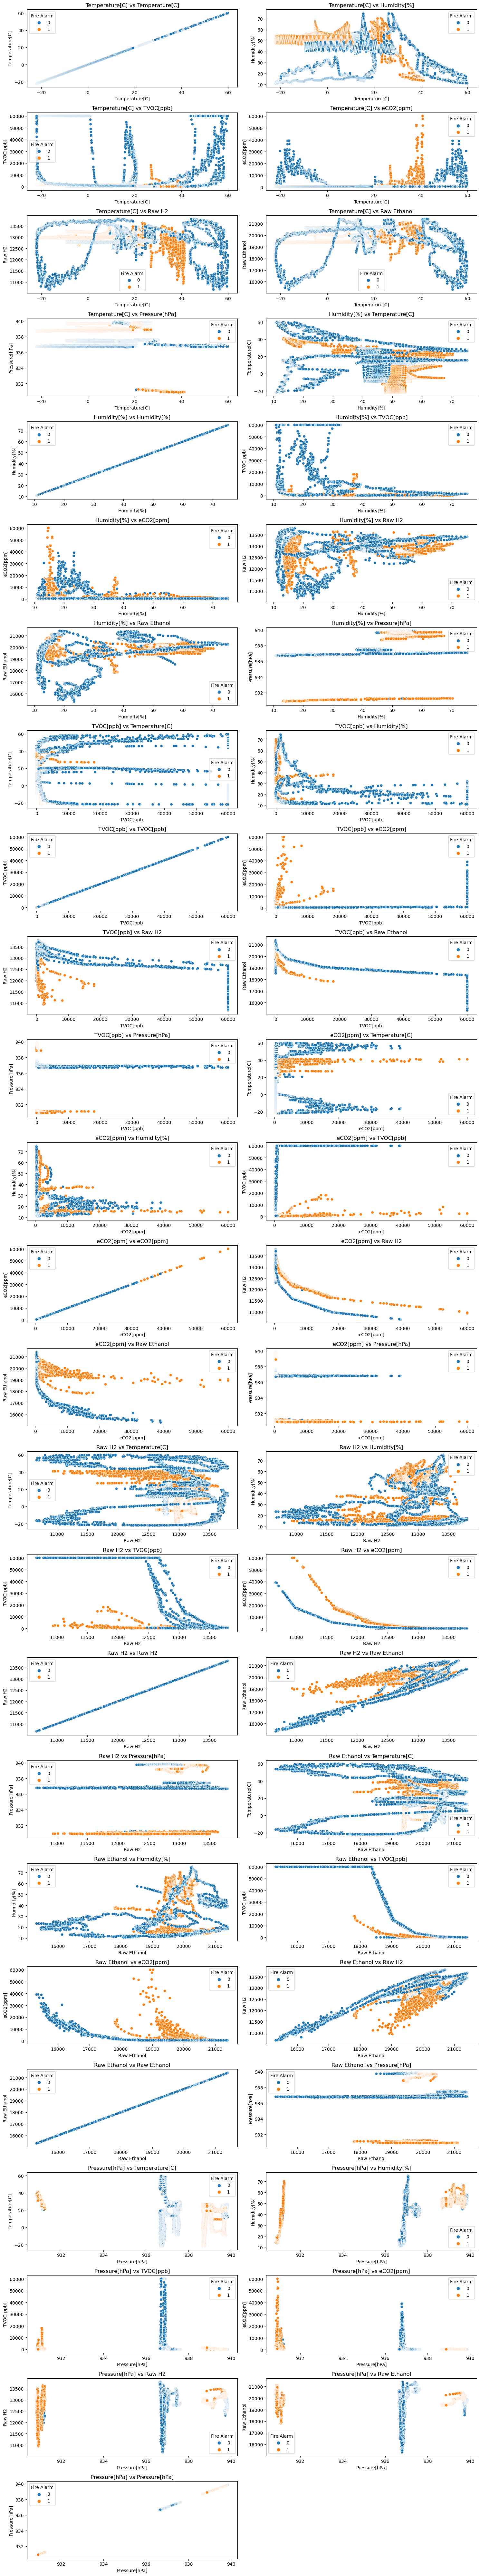

In [11]:
selected_vars = ['Temperature[C]','Humidity[%]','TVOC[ppb]','eCO2[ppm]','Raw H2','Raw Ethanol',	'Pressure[hPa]']


plt.figure(figsize=(15,80))

v = 1  # Counter for subplot index

for i in selected_vars:
    for j in selected_vars:
        plt.subplot(25, 2, v)
        sns.scatterplot(x=i, y=j, data=data,hue='Fire Alarm')
        plt.title(f'{i} vs {j}')
        v += 1


plt.tight_layout()
plt.show()XX

In [12]:
temp_model = RandomForestClassifier(n_estimators=250)
temp_model.fit(data[data.columns.drop(['Fire Alarm','UTC'])].to_numpy(),data['Fire Alarm'].to_numpy())

RandomForestClassifier(n_estimators=250)

<Axes: >

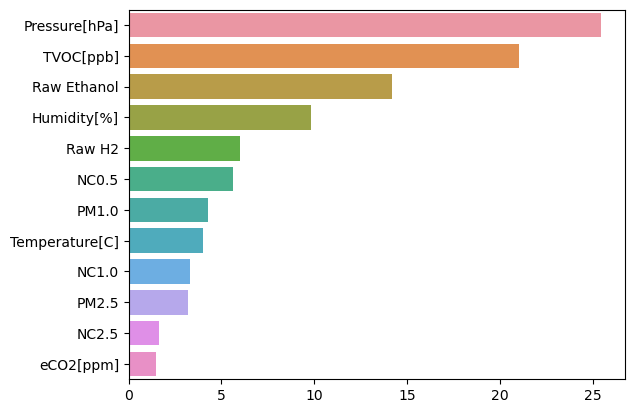

In [13]:
importance = temp_model.feature_importances_*100
order = np.argsort(importance)[::-1]
sns.barplot(x=np.sort(importance)[::-1],y=data.columns.drop(['Fire Alarm','UTC'])[order])

In [14]:
def train_model(models:list,test_x:np.ndarray,test_y:np.ndarray,train_x:np.ndarray,train_y:np.ndarray,eval:dict):
    keys = list(eval.keys())
    for i,j in enumerate(models):
        j.fit(train_x,train_y)
        pred = j.predict(test_x)
        eval[keys[i]]["precision"].append(precision_score(test_y,pred))
        eval[keys[i]]["accuracy"].append(accuracy_score(test_y,pred))
        eval[keys[i]]["recall"].append(recall_score(test_y,pred))
        eval[keys[i]]["f1"].append(f1_score(test_y,pred))



In [15]:
scalar = StandardScaler()
X = data[data.columns.drop(['Fire Alarm','UTC','NC2.5','NC1.0','PM2.5','PM1.0'])].to_numpy()
y = data['Fire Alarm'].to_numpy()
X = scalar.fit_transform(X)
skf = StratifiedKFold(n_splits=7,shuffle=True,random_state=42)
index = skf.split(X,y)
eval = {"log":{"precision":[],"recall":[],"f1":[],"accuracy":[]},"random":{"precision":[],"recall":[],"f1":[],"accuracy":[]},
        "svm":{"precision":[],"recall":[],"f1":[],"accuracy":[]},"KNN":{"precision":[],"recall":[],"f1":[],"accuracy":[]},
        "ada":{"precision":[],"recall":[],"f1":[],"accuracy":[]}, "gradient":{"precision":[],"recall":[],"f1":[],"accuracy":[]}
        }
train_models = [LogisticRegression(max_iter=1000),RandomForestClassifier(),SVC(),KNeighborsClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]
for train,test in index:
    train_model(train_models,X[test],y[test],X[train],y[train],eval)


In [16]:
summary = {
    "model":[],
    "precision":[],
    "recall":[],
    "f1_score":[],
    "accuracy":[]D
}
for i in eval.keys():
    summary["model"].append(i)
    summary["precision"].append(np.mean(eval[i]["precision"]))
    summary["recall"].append(np.mean(eval[i]["recall"]))
    summary["accuracy"].append(np.mean(eval[i]["accuracy"]))
    summary["f1_score"].append(np.mean(eval[i]["f1"]))
pd.DataFrame(summary).style.background_gradient(cmap="Blues")

In [17]:
params_grid = {
    'n_estimators':[100,150,200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features':['log2','sqrt']
}

In [18]:
model = RandomForestClassifier()
grid_search = GridSearchCV(model,param_grid=params_grid,cv=StratifiedKFold(n_splits=7) ,scoring=['recall', 'precision'],refit="recall",n_jobs=5)
grid_search.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 150, 200]},
             refit='recall', scoring=['recall', 'precision'])

In [19]:
new_skf = StratifiedKFold(n_splits=7,shuffle=True,random_state=42)
new_index = new_skf.split(X,y)
j = 1
for train,test in new_index:
    grid_search.best_estimator_.fit(X[train],y[train])
    print("Fold",j)
    print(classification_report(y[test],grid_search.best_estimator_.predict(X[test])))
    j += 1

Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2554
           1       1.00      1.00      1.00      6394

    accuracy                           1.00      8948
   macro avg       1.00      1.00      1.00      8948
weighted avg       1.00      1.00      1.00      8948

Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2554
           1       1.00      1.00      1.00      6393

    accuracy                           1.00      8947
   macro avg       1.00      1.00      1.00      8947
weighted avg       1.00      1.00      1.00      8947

Fold 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2553
           1       1.00      1.00      1.00      6394

    accuracy                           1.00      8947
   macro avg       1.00      1.00      1.00      8947
weighted avg       1.00      1.00      1.00      8947

In [20]:
grid_search.best_estimator_.fit(X,y)

RandomForestClassifier(criterion='log_loss', n_estimators=150)

In [21]:
pickle.dump(grid_search.best_estimator_,open("../model.pkl","wb"))